Libraries

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 94.4 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, Dataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
import shutil
import random
from torchvision import datasets, transforms
#from tqdm import tqdm, trange
from sklearn.metrics import f1_score, precision_score, recall_score
from transformers import get_linear_schedule_with_warmup

**download dataset**

In [ ]:
dataset=datasets.CIFAR10(root="pics",
                              train=True,
                              download=True,
                              transform=transforms.ToTensor())

test_dataset=datasets.CIFAR10(root="pics",
                              train=True,
                              download=True,
                              transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:05<00:00, 29056286.47it/s]


Extracting pics/cifar-10-python.tar.gz to pics
Files already downloaded and verified


Dataset split

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);

In [ ]:
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

mean and std calculate for 3 channel(rgb) images

In [ ]:
for images,_ in dataset:
  image_tensor_normalized = images.float()

mean = torch.mean(images, dim=(1, 2))
std = torch.std(images, dim=(1, 2))

print("Mean:", mean)
print("Standard Deviation:", std)

Mean: tensor([0.5441, 0.5082, 0.4992])
Standard Deviation: tensor([0.2079, 0.2274, 0.2435])


In [ ]:
mean.shape

torch.Size([3])

Transforms-with normalization

In [ ]:
transformania = transforms.Compose([transforms.ToTensor(),
                                    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                         transforms.RandomHorizontalFlip(),
                         transforms.RandomRotation(15),
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)),
                         #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         transforms.Normalize(mean=mean,std=std)])

In [ ]:
train_ds.dataset.transform = transformania
val_ds.dataset.transform = transforms.Compose([transforms.ToTensor(),
                                               transforms.Normalize(mean=mean,std=std)])

In [ ]:
#verify
for images,_ in dataset:
  image_tensor_normalized = images.float()

mean = torch.mean(images, dim=(1, 2))
std = torch.std(images, dim=(1, 2))

print("Mean:", mean)
print("Standard Deviation:", std)

Mean: tensor([3.5577e-07, 2.3283e-09, 3.5390e-07])
Standard Deviation: tensor([1.0000, 1.0000, 1.0000])


dataset playing

In [ ]:
len(dataset)

50000

In [ ]:
image,label=dataset[0]
image.shape

torch.Size([3, 32, 32])

In [ ]:
dataset[0][0].shape

torch.Size([3, 32, 32])

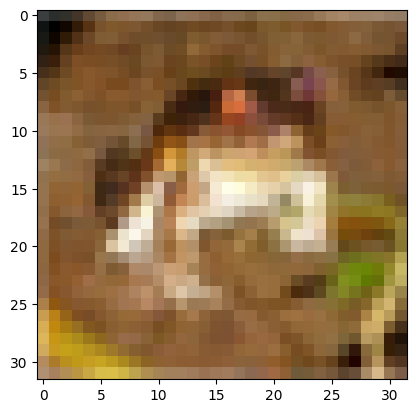

In [ ]:
plt.imshow(image.permute(1,2,0))

In [ ]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  horse (7)


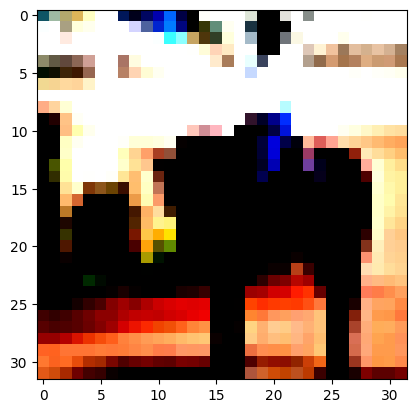

In [ ]:
show_example(*dataset[11])

Dataloader

In [ ]:
#arguments
train_batch_size=256
val_batch_size=512
test_batch_size=512
input_size=28*28
classes=10

In [ ]:
train_loader=DataLoader(train_ds,train_batch_size,shuffle=True)
val_loader=DataLoader(val_ds,val_batch_size,shuffle=True)

In [ ]:
#test data
test_loader=DataLoader(test_dataset,test_batch_size)

Arguments

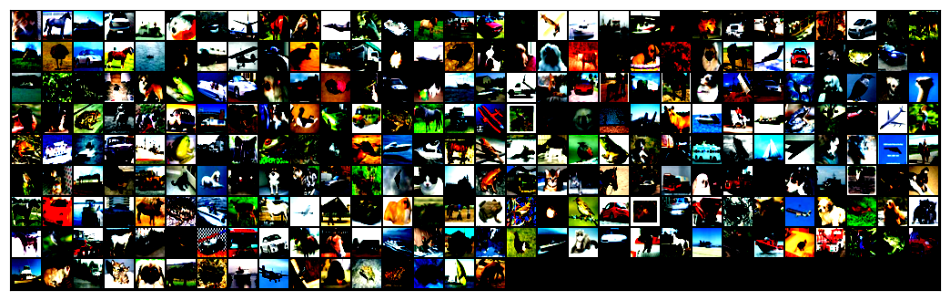

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=30).permute(1, 2, 0))
        break

show_batch(train_loader)

USE GPU

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def device_type():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')


def to_device(data,device):#transfer to gpu
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device, non_blocking= True)


class deviceDataloader():#wrap dataloaders
  def __init__(self,dl,device):
    self.dl=dl
    self.device=device

  def __iter__(self):
    for batchy in self.dl:
      yield to_device(batchy,self.device)

  def __len__(self):
    return len(self.dl)

In [ ]:
device=device_type()
device

device(type='cuda')

In [ ]:
train_loader=deviceDataloader(train_loader,device)
val_loader=deviceDataloader(val_loader,device)
test_loader=deviceDataloader(test_loader,device)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return loss,acc

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f} , train_loss: {:.4f} , train_acc: {:.4f} , val_loss: {:.4f} , val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.conv1 = conv_block(3, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, 10))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

Training Steps

In [ ]:
args = {}

args["num_train_epochs"] = 30
args["optimizer"] = torch.optim.Adam
args["learning_rate"] = 1e-2
args["weight_decay"] = 1e-8
args["grad_clip"] = None
args["adam_epsilon"] = 1e-8
args["output_dir"] = "./output/"
args["max_grad_norm"] = 1.0
args["save_steps"] = 1
args["dropout"] = 0.3
args["lambda"] = 0.001

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs=[model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(args,model,train_loader,val_loader):
  torch.cuda.empty_cache()
  history=[]

  optimizer=args["optimizer"](model.parameters(), lr=args["learning_rate"],weight_decay=args["weight_decay"])
  sched=torch.optim.lr_scheduler.OneCycleLR(optimizer,args["learning_rate"], epochs=args["num_train_epochs"],
                                            steps_per_epoch=len(train_loader))

  for epoch in range(args["num_train_epochs"]):
    model.train()
    train_losses=[]
    train_accs=[]
    lrs=[]
    for batch in train_loader:
          loss,acc=model.training_step(batch)
          train_losses.append(loss)
          train_accs.append(acc)
          loss.backward()

          # Gradient clipping
          if args["grad_clip"]:
            nn.utils.clip_grad_value_(model.parameters(), args["grad_clip"])

          optimizer.step()
          optimizer.zero_grad()

          # Record & update learning rate
          lrs.append(get_lr(optimizer))
          sched.step()

    #validation
    result=evaluate(model,val_loader)
    result['train_loss']=torch.stack(train_losses).mean().item()
    result['train_acc']=torch.stack(train_accs).mean().item()
    result["lrs"]=lrs
    model.epoch_end(epoch,result)
    history.append(result)

  return history

TRAIN/TEST

In [ ]:
result0=evaluate(model,val_loader)
result0

{'val_loss': 2.3037071228027344, 'val_acc': 0.10368303954601288}

In [ ]:
%%time
try1=fit(args,model,train_loader,val_loader)

Epoch [0], last_lr: 0.00069 , train_loss: 1.4009 , train_acc: 0.5088 , val_loss: 1.1637 , val_acc: 0.6022
Epoch [1], last_lr: 0.00152 , train_loss: 0.8861 , train_acc: 0.6912 , val_loss: 0.9290 , val_acc: 0.6877
Epoch [2], last_lr: 0.00279 , train_loss: 0.7146 , train_acc: 0.7543 , val_loss: 0.8963 , val_acc: 0.7110
Epoch [3], last_lr: 0.00436 , train_loss: 0.6273 , train_acc: 0.7872 , val_loss: 1.2373 , val_acc: 0.6595
Epoch [4], last_lr: 0.00603 , train_loss: 0.5620 , train_acc: 0.8136 , val_loss: 0.8238 , val_acc: 0.7361
Epoch [5], last_lr: 0.00760 , train_loss: 0.4712 , train_acc: 0.8415 , val_loss: 1.0309 , val_acc: 0.6948
Epoch [6], last_lr: 0.00888 , train_loss: 0.3704 , train_acc: 0.8745 , val_loss: 0.4838 , val_acc: 0.8409
Epoch [7], last_lr: 0.00971 , train_loss: 0.2641 , train_acc: 0.9093 , val_loss: 0.7517 , val_acc: 0.7919
Epoch [8], last_lr: 0.01000 , train_loss: 0.1984 , train_acc: 0.9320 , val_loss: 0.6161 , val_acc: 0.8195
Epoch [9], last_lr: 0.00994 , train_loss: 0.15

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

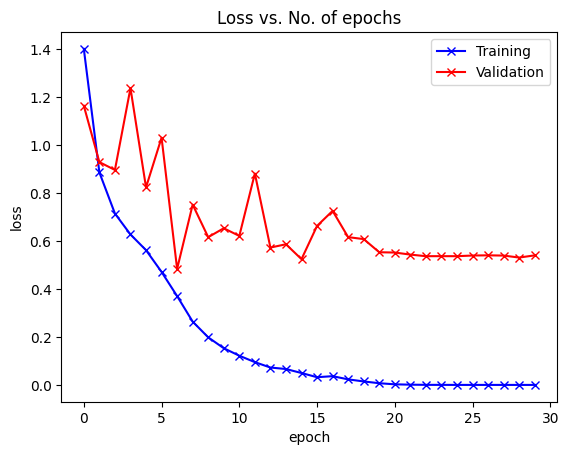

In [ ]:
plot_losses(try1)

In [ ]:
#save

torch.save(model.state_dict(),'resnet.pth')

In [ ]:
evaluate(model,test_loader)

{'val_loss': 2.707817554473877, 'val_acc': 0.3590864837169647}